# Test Minimum Spanning Tree (MST)

In [1]:
# packages for graphics
import seaborn as sns
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# inline matplotlib
%matplotlib inline

In [2]:
# networks
import networkx
from networkx.drawing.nx_agraph import graphviz_layout

In [3]:
from sklearn.neighbors import KernelDensity

In [4]:
# date and time
import datetime
import dateutil
import time
from timeit import default_timer as timer

In [46]:
import numpy as np
import pandas as pd
import h5py
from numba import jit, prange


In [83]:
# define random seed
randomSeed=1234567

The data for the project is pulled using the Norgate API (https://pypi.org/project/norgatedata/) and stored in h5 files.

This notebook demonstrates how to read the h5 files for each of the instrument universes monitored in the shared h5 directory.


In [6]:
# define universe
#universe='DJI'
universe='SP100'
# define h5 input directory and file name
#inputDirectoryH5='F:/marketData/global_monitoring/premium/h5/'
inputDirectoryH5='/home/dockeruser/hosthome/DATA_698/data/'
inputFileNameH5=universe+'_premium.h5'

Open the h5 file and list the available fields:

In [7]:
# open file handle
fileHandleH5 = h5py.File(inputDirectoryH5+inputFileNameH5, 'r')
# find keys
list(fileHandleH5.keys())


['adjustedClose',
 'adjustedDividend',
 'adjustedHigh',
 'adjustedLow',
 'adjustedOpen',
 'adjustedTurnover',
 'adjustedVolume',
 'atr',
 'capitalAdjClose',
 'capitalAdjDividend',
 'capitalAdjHigh',
 'capitalAdjLow',
 'capitalAdjOpen',
 'capitalAdjTurnover',
 'capitalAdjVolume',
 'indexConstituent',
 'specialCapitalAdjClose',
 'specialCapitalAdjDividend',
 'specialCapitalAdjHigh',
 'specialCapitalAdjLow',
 'specialCapitalAdjOpen',
 'specialCapitalAdjTurnover',
 'specialCapitalAdjVolume',
 'trueRange',
 'unadjustedClose',
 'unadjustedDividend',
 'unadjustedHigh',
 'unadjustedLow',
 'unadjustedOpen',
 'unadjustedTurnover',
 'unadjustedVolume']

Read in the instrument constituent flag, the adjusted close price and true range from the h5 file:

In [8]:
# extract index constituent flag
indexConstituent = pd.read_hdf(inputDirectoryH5+inputFileNameH5,'indexConstituent')
# extract adjusted close
price = pd.read_hdf(inputDirectoryH5+inputFileNameH5,'adjustedClose')
# extract true range
trueRange = pd.read_hdf(inputDirectoryH5+inputFileNameH5,'trueRange')


The instrument master is not in the h5 file yet, but it eventually will just be available under another 'instrumentMaster' key.

Read instrument master:

In [9]:
# define instrument master directory and file name
inputFileMaster=universe+'.csv'
#inputDirectoryMaster='F:/marketData/global_monitoring/premium/'+universe+'/instrument_master/'
inputDirectoryMaster='/home/dockeruser/hosthome/DATA_698/data/'
# read instrument master
instrumentMaster=pd.read_csv(inputDirectoryMaster+inputFileMaster)

In [10]:
instrumentMaster.head()

,assetId,securityname,symbol,business_summary,gics_level_1,gics_level_2,gics_level_3,gics_level_4,currency,domicile
0,136817,Apple Inc Common,AAPL,"Apple Inc. designs, manufactures and markets m...",Information Technology,Technology Hardware & Equipment,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals",USD,United States Of America
1,697433,Abbvie Inc Common,ABBV,AbbVie Inc. (AbbVie) is a research-based bioph...,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Biotechnology,Biotechnology,USD,United States Of America
2,146374,Abbott Laboratories Common,ABT,Abbott Laboratories is engaged in the discover...,Health Care,Health Care Equipment & Services,Health Care Equipment & Supplies,Health Care Equipment,USD,United States Of America
3,134666,Accenture PLC Class A Common,ACN,Accenture plc is a professional services compa...,Information Technology,Software & Services,IT Services,IT Consulting & Other Services,USD,Ireland
4,141248,Adobe Inc Common,ADBE,"Adobe Inc., formerly Adobe Systems Incorporate...",Information Technology,Software & Services,Software,Application Software,USD,United States Of America


Compute log returns:

In [12]:
# log price by instrument
logPrice=np.log(price)
# first difference to get returns
logReturn=logPrice.diff(periods=1,axis=0)

Create a rolling version of the standardization:

In [18]:
# define the size of the rolling window in days
lookback=250
# set raw flag
rawFlag=True
# compute rolling mean log return
meanLogReturn=logReturn.rolling(window=lookback).apply(np.mean,raw=rawFlag)
# compute rolling mean standard deviation of log return
sdLogReturn=logReturn.rolling(window=lookback).apply(np.std,raw=rawFlag)
# compute rolling standardized return
zLogReturn=(logReturn-meanLogReturn)/sdLogReturn

In [19]:
zLogReturn

assetId,124968,125055,125360,125597,125718,126039,126090,126228,126558,126852,...,618960,697433,946292,1500297,1565068,2073582,2073583,2176924,2314464,2505190
Date,,,,,,,,,,,,,,,,,,,,,
1989-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989-09-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989-09-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989-09-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-08,-1.091001,-1.302803,-0.930532,NaN,-2.293625,-0.397379,-1.159509,-1.345260,-0.466918,-0.135858,...,-0.539355,-0.503236,NaN,-0.846232,NaN,-0.218646,-1.161235,-1.345174,-1.167110,NaN
2019-10-09,0.741315,0.581999,0.745726,NaN,0.598509,0.105597,0.461583,-0.921246,-0.417607,0.062385,...,0.533149,-0.119763,NaN,0.581931,NaN,0.130377,0.224765,0.694781,-0.032646,NaN
2019-10-10,-0.330919,0.646859,0.603444,NaN,0.542238,0.672523,0.378032,-0.592148,1.793888,-0.257957,...,0.017291,0.813734,NaN,0.264798,NaN,0.390675,0.267810,0.612422,-1.125225,NaN


Text(0, 0.5, 'Log-Return')

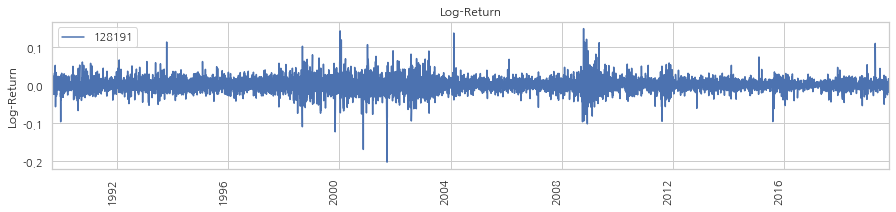

In [20]:
# define title
titleName='Log-Return'
# display the returns
logReturn[128191].plot(legend=True,figsize=(15,3),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Log-Return")

Text(0, 0.5, 'Log-Return')

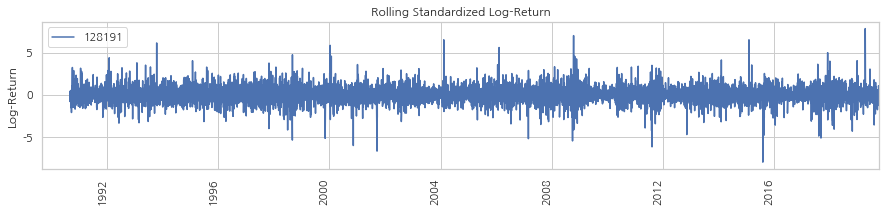

In [21]:
# define title
titleName='Rolling Standardized Log-Return'
# display the returns
zLogReturn[128191].plot(legend=True,figsize=(15,3),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Log-Return")

In [22]:
# packages for clustering
from scipy.linalg import block_diag
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform

In [23]:
# networks
import networkx
from networkx.drawing.nx_agraph import graphviz_layout

In [ ]:

# create the directory if it does not exist
#ensure_directory(outputDirectory)  

In [24]:
# 
outputDirectory='/home/dockeruser/DATA_698/data/'


In [25]:
print(outputDirectory+universe+'_rollingCorrelation.h5')
print(universe+'_rollingCorrelation')

/home/dockeruser/DATA_698/data/SP100_rollingCorrelation.h5
SP100_rollingCorrelation


In [30]:
# compute rolling correlation for rolling standardized log returns
def computeRollingCorrelations(zLogReturn,lookback,directory,fileName,computeFlag=True,centerFlag=False):
    # full file name
    outputFullName=directory+fileName
    # start timer (compute rolling correlation)
    ts = timer()    
    # compute centered rolling log-return correlations
    rollingCorrelation=zLogReturn.rolling(window=lookback,
        min_periods=lookback,center=centerFlag).corr(pairwise=True)
    # end timer (compute rolling correlation)
    te_compute = timer()
    # create the HDF5 data store for rolling correlations (not centered)
    rollingCorrelation.to_hdf(outputFullName,'rollingCorrelation')
    # end timer (compute rolling correlation)
    te_write = timer()
    # compute time elasped
    timeElasped_compute=te_compute-ts
    timeElasped_write=te_write-te_compute
    # display time elasped
    print('Time Elasped: '+str(timeElasped_compute))
    print('Time Elasped: '+str(timeElasped_write))        
        
    return rollingCorrelation

def getRollingCorrelations(zLogReturn,lookback,universe,outputType,directory,computeFlag=True,centerFlag=False):
    # create file name
    fileName=universe+'_'+str(lookback)+'_'+outputType+'.h5'
    # full file name
    outputNameFull=directory+fileName    
    
    if (computeFlag):
        # compute rolling correlation
        rollingCorrelation=computeRollingCorrelations(zLogReturn,lookback,directory,
            fileName,computeFlag,centerFlag)
    else:    
        # read rolling log-return correlations panel from the HDF5 results store
        rollingCorrelation = pd.read_hdf(outputNameFull,'rollingCorrelation')
        
    return rollingCorrelation


In [43]:
# create random returns
nDays,nInstruments=zLogReturn.shape
# create random log return
randomLogReturn=pd.DataFrame(index=zLogReturn.index,data=np.random.randn(nDays,nInstruments),
    columns=zLogReturn.columns)


In [84]:
#
nanIndex=zLogReturn.isna()
#
randomLogReturn[nanIndex]=np.nan

In [44]:
randomLogReturn.head()

assetId,124968,125055,125360,125597,125718,126039,126090,126228,126558,126852,...,618960,697433,946292,1500297,1565068,2073582,2073583,2176924,2314464,2505190
Date,,,,,,,,,,,,,,,,,,,,,
1989-09-01,-0.795430,-0.361554,-0.291029,0.067543,1.433111,-0.329994,-0.030798,0.402063,-0.961757,-0.146748,...,-0.253048,1.750786,-0.521447,0.632136,-0.041454,-0.920817,0.028851,0.911511,-0.789549,0.085140
1989-09-05,0.001325,-1.133710,0.044998,0.231757,0.482982,0.240787,-0.492297,-0.091476,0.952268,0.055390,...,0.533455,-1.991348,0.021379,0.641947,1.127410,-1.413186,-0.141037,-0.193961,-1.647908,-0.520311
1989-09-06,0.129809,0.855160,0.603572,-0.936760,0.244495,0.456495,1.906396,-0.236192,-0.486503,-0.361219,...,0.516334,-0.708287,-0.723570,2.489516,-0.223918,-0.945840,-0.597143,0.920529,-0.138030,-1.299094
1989-09-07,0.251349,-1.038026,-1.370730,-0.948668,-0.169996,0.227353,0.454616,-0.710925,-0.494963,0.658215,...,-0.707238,0.565410,0.016048,0.332789,0.732476,-0.402570,-0.667035,1.251624,-0.837542,-1.464366
1989-09-08,2.149219,0.991970,-1.133763,-1.448997,0.487138,0.252406,0.431874,-1.056085,0.015947,-0.865870,...,0.671251,1.235487,0.305417,-0.055825,0.978031,0.600476,-0.612147,0.256009,-1.056072,0.873309


In [75]:
#
def nans(shape, dtype=float):
    a = np.empty(shape, dtype)
    a.fill(np.nan)
    return a
#
def shuffleByColumnNumba(x,randomSeed):
    np.random.seed(randomSeed)
    xShape=x.shape
    xShuffle=nans(xShape)
    for columnIndex in range(0,xShape[1]):
        # find non-NaNs
        notNanIndex=~np.isnan(x[:,columnIndex])
        # shuffle data
        xShuffle[notNanIndex,columnIndex]=np.random.choice(x[notNanIndex,columnIndex], 
            size=len(x[notNanIndex,columnIndex]), replace=False)

    return xShuffle


In [78]:
#
shuffledLogReturn=pd.DataFrame(index=zLogReturn.index,
    data=shuffleByColumnNumba(zLogReturn.values,randomSeed),columns=zLogReturn.columns)


In [ ]:
# define flag to compute rolling correlations
computeRollingCorrelationsFlag=True
# define flag to compute rolling PCA
computeRollingPCA=True
# define flag to compute rolling MST (unfiltered)
computeUnfilteredMST=False
# define flag to compute rolling MST (filtered)
computeFilteredMST=False


# define output type
outputType='rollingCorrelation'
# compute rolling correlations
rollingCorrelation=getRollingCorrelations(zLogReturn,lookback,universe,outputType,
    outputDirectory,computeFlag=computeRollingCorrelationsFlag)
# define output type
outputType='randomRollingCorrelation'
# compute rolling correlations (random returns)
randomRollingCorrelation=getRollingCorrelations(randomLogReturn,lookback,universe,outputType,
    outputDirectory,computeFlag=computeRollingCorrelationsFlag)
# define output type
outputType='shuffledRollingCorrelation'
# compute rolling correlations (shuffled returns)
shuffledRollingCorrelation=getRollingCorrelations(shuffledLogReturn,lookback,universe,outputType,
    outputDirectory,computeFlag=computeRollingCorrelationsFlag)


In [42]:
# extract datetimes
dateTimes=rollingCorrelation.index.levels[0]
# extract GICs sector tickers
tickers=rollingCorrelation.index.levels[1].values
# create weekly index (each Friday)
weeklyIndex=rollingCorrelation.index.levels[0].dayofweek==4
# extract weekly datetimes
weeklyDateTimes=dateTimes[weeklyIndex]

In [ ]:
currentCorrelation=rollingCorrelation.loc[weeklyDateTimes[-1]]

In [ ]:
currentCorrelation

In [ ]:

#
naIndex=~currentCorrelation.iloc[0].notna()



In [87]:
# define function to extract correlation for index constituents with enough historical data for datetime
def extractCorrelationForDate(rollingCorrelation,shuffledCorrelation,randomCorrelation,indexConstituent,dateTime):
    # extract correlation for datetime
    C=rollingCorrelation.loc[dateTime]
    shuffledC=shuffledCorrelation.loc[dateTime]
    randomC=randomCorrelation.loc[dateTime]
    # find index constituents
    constituentIndex=indexConstituent.loc[dateTime]==1.0
    # extract current correlations for index constituents
    C=C.loc[constituentIndex.values,constituentIndex.values].copy()
    shuffledC=shuffledC.loc[constituentIndex.values,constituentIndex.values].copy()
    randomC=randomC.loc[constituentIndex.values,constituentIndex.values].copy()
    # create index to remove NAs (not enough historical return data)
    nonNaIndex=C.iloc[0].notna()
    # index into current correlation matrix to exclude NAs and return
    return C.loc[nonNaIndex,nonNaIndex].copy(),shuffledC.loc[nonNaIndex,nonNaIndex].copy(),randomC.loc[nonNaIndex,nonNaIndex].copy()

def flattenCorrelationForDistribution(CC):
    DD=CC.copy()
    # mask the upper half of the correlation matrix including the diagonal
    DD.values[np.triu_indices(DD.shape[0])]=np.nan
    # drop upper half of correlation matrix and flatten
    return DD.unstack().dropna()


In [ ]:
dateTime=weeklyDateTimes[-1]
CC,shuffledC,randomC=extractCorrelationForDate(rollingCorrelation,randomRollingCorrelation,
    shuffledRollingCorrelation,indexConstituent,dateTime)

In [ ]:
CC

Filter correlation matrix for momentum:

Convert correlation matrix to distribution:

In [ ]:
flatCC=flattenCorrelationForDistribution(CC)

In [ ]:
flatCC.head()

In [ ]:
flatCC.plot(kind='hist')

In [ ]:
flatCC.plot(kind='kde')

In [ ]:
#
sns.clustermap(CC,method="single",linewidths=0, figsize=(13, 13))

In [ ]:
def marcenkoPasturC_Q(Q):
    q = 1 / float(Q)
    lambda_min = (1 - np.sqrt(q))**2
    lambda_max = (1 + np.sqrt(q))**2

    def rho(x):
        ret = np.sqrt((lambda_max - x) * (x - lambda_min))
        ret /= 2 * np.pi * q * x
        return ret if lambda_min < x < lambda_max else 0.0

    return (lambda_min, lambda_max), rho

def marcenkoPasturC(T, N):
    q = N / float(T)
    lambda_min = (1 - np.sqrt(q))**2
    lambda_max = (1 + np.sqrt(q))**2

    def rho(x):
        ret = np.sqrt((lambda_max - x) * (x - lambda_min))
        ret /= 2 * np.pi * q * x
        return ret if lambda_min < x < lambda_max else 0.0

    return (lambda_min, lambda_max), rho

def eigenvaluePdfViaMcVsMarcenkoPastur(nDays, nInstruments,xEigenvaluesN):
    
    # find upper and lower bounds for eigenvalues and return Marcenko Pastur PDF function
    (lambdaMin, lambdaMax), rho=marcenkoPasturC(nDays, nInstruments)
    # create eigenvalue x
    xEigenvalues=np.linspace(lambdaMin, lambdaMax,xEigenvaluesN)
    # define Marcenko Pastur PDF lamda function 
    f = lambda x : rho(x)
    # create table to store results
    theoreticalEigenvaluePdfDf=pd.DataFrame(xEigenvalues,columns=['xEigenvalues'])
    # compute theoretical PDF according to Marcenko Pastur
    # -evaluate theoretical PDF at each eigenvalue x
    theoreticalEigenvaluePdfDf['pdf']=theoreticalEigenvaluePdfDf['xEigenvalues'].apply(f)
    # simulate nDays x nInstruments standardized returns
    r=np.reshape(np.random.normal(0,1,nDays*nInstruments),(nDays,nInstruments))
    # covert r to dataframe
    r=pd.DataFrame(r)
    # compute correlation matrix
    C=r.corr()
    # eigen-decomposition of correlation matrix
    eigenvalues, eigenvectors = np.linalg.eigh(C)
    # sort the eigenvalues and eigenvalues
    sortIndex=np.argsort(-eigenvalues)
    eigenvalues=eigenvalues[sortIndex]
    eigenvectors=eigenvectors[:,sortIndex]    
    
    return eigenvalues,theoreticalEigenvaluePdfDf

def plotEigenvaluePdfViaMcVsMarcenkoPastu(eigenvalues,theoreticalEigenvaluePdfDf,figureSize):
    # set figure size
    plt.figure(figsize=figureSize)
    # plot 
    plt.plot(theoreticalEigenvaluePdfDf['xEigenvalues'],theoreticalEigenvaluePdfDf['pdf'])
    # plot histogram
    plt.hist(eigenvalues,bins=75,density=True)
    # add x-label
    plt.xlabel('Eigenvalue')
    # add y-label
    plt.ylabel('Frequency')
    # add title
    plt.title('Eigenvalue PDF')    
    
    return

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

def shuffleDataFrame(df):
    return df.reindex(numpy.random.permutation(df.index))

def eigenvalueKdePdfBoundsViaMc(output_directory,nDays,nInstruments,nPaths,xEigenvaluesN,bandwidth,percentiles):

    dateTime=datetime.datetime.now()
    # set the HDF5 output file directory

    # create the directory if it does not exist
    ensure_directory(output_directory)    
    # create output file
    output_file='eigenvalueMC_'+str(nDays)+'_x_'+str(nInstruments)+'.h5'
    
    # find upper and lower bounds for eigenvalues and return Marcenko Pastur PDF function
    (lambdaMin, lambdaMax), rho=marcenkoPasturC(nDays, nInstruments)
    # create eigenvalue x
    xEigenvalues=np.linspace(lambdaMin, lambdaMax,xEigenvaluesN)
    # define Marcenko Pastur PDF lamda function 
    f = lambda x : rho(x)
    # create table to store results
    theoreticalEigenvaluePdfDf=pd.DataFrame(xEigenvalues,columns=['xEigenvalues'])
    # compute theoretical PDF according to Marcenko Pastur
    # -evaluate theoretical PDF at each eigenvalue x
    theoreticalEigenvaluePdfDf['pdf']=theoreticalEigenvaluePdfDf['xEigenvalues'].apply(f)

    # create matrix to store eigenvalues
    eigenvaluesByPath=np.zeros([nInstruments,nPaths])
    # create matrix to store eigenvalue KDE PDF
    eigenvaluesPdfByPath=np.zeros([xEigenvaluesN,nPaths])
    # iterate over each path
    for pathIndex in range(0,nPaths):
        # simulate nDays x nInstruments standardized returns
        r=np.reshape(np.random.normal(0,1,nDays*nInstruments),(nDays,nInstruments))
        # covert r to dataframe
        r=pd.DataFrame(r)
        # compute correlation matrix
        C=r.corr()
        # eigen-decomposition of correlation matrix
        eigenvalues, _ = np.linalg.eigh(C)
        # sort the eigenvalues and eigenvalues
        sortIndex=np.argsort(-eigenvalues)
        eigenvalues=eigenvalues[sortIndex]
        # do kernal smoothed density estimate
        pdf=kde_sklearn(eigenvalues, xEigenvalues, bandwidth=bandwidth)
        # store eigenvalue KDE PDF
        eigenvaluesPdfByPath[:,pathIndex]=pdf
        # store eigenvalues
        eigenvaluesByPath[:,pathIndex]=eigenvalues

    # percentile bounds
    eigenvalueBounds=np.percentile(eigenvaluesByPath, percentiles, axis=1).T        
    # percentile bounds
    eigenvaluePdfBounds=np.percentile(eigenvaluesPdfByPath, percentiles, axis=1).T
    # create eigenvalues by path dataframe
    eigenvaluesByPathDf=pd.DataFrame(eigenvaluesByPath)
    # create eigenvalue KDE PDF dataframe
    eigenvaluesPdfByPathDf=pd.DataFrame(eigenvaluesPdfByPath)
    # create eigenvalue bounds dataframe
    eigenvalueBoundsDf=pd.DataFrame(eigenvalueBounds,columns=percentiles)   
    # create eigenvalue KDE PDF bounds dataframe
    eigenvaluePdfBoundsDf=pd.DataFrame(eigenvaluePdfBounds,columns=percentiles)
    
    # store simulation parameters
    simulationParameters=dict()
    simulationParameters['nDays']=nDays
    simulationParameters['nInstruments']=nInstruments
    simulationParameters['nPaths']=nPaths
    simulationParameters['bandwidth']=bandwidth
    simulationParameters['xEigenvaluesN']=xEigenvaluesN
    simulationParameters['lambdaMin']=lambdaMin
    simulationParameters['lambdaMax']=lambdaMax
    #simulationParameters['percentiles']=percentiles
    # convert to dataframe
    simulationParametersDf=pd.DataFrame.from_dict(simulationParameters,orient='index')
    # set column name
    simulationParametersDf.rename(columns={0 : 'parameterValue'},inplace=True)

    # create the HDF5 data store
    data_store = pd.HDFStore(output_directory+output_file)
    # store theoretical eigenvalues dataframe
    data_store['theoreticalEigenvaluePdfDf'] = theoreticalEigenvaluePdfDf
    # store eigenvalue by path dataframe in the HDF5 data store
    data_store['eigenvaluesByPath'] = eigenvaluesByPathDf
    # store the eigenvalue KDE PDF by path dataframe in the HDF5 data store
    data_store['eigenvaluesPdfByPath'] = eigenvaluesPdfByPathDf
    # store eigenvalue bounds dataframe in the HDF5 data store
    data_store['eigenvalueBounds'] = eigenvalueBoundsDf
    # store eigenvalue KDE PDF bounds dataframe in the HDF5 data store
    data_store['eigenvaluePdfBounds'] = eigenvaluePdfBoundsDf
    # store simulation parameters dataframe
    data_store['simulationParameters'] = simulationParametersDf
    # close the HDF5 data store
    data_store.close()    
    
    return output_file,theoreticalEigenvaluePdfDf,eigenvaluesByPathDf,eigenvaluesPdfByPathDf,eigenvalueBoundsDf,eigenvaluePdfBoundsDf,simulationParametersDf

def plotActualVsTheoreticalEigenvaluePDF(nDays, nInstruments,eigenvalues,kdeFlag,figureSize):
    # find theoretical upper and lower bounds for eigenvalues + return Marcenko Pastur PDF function
    (lambdaMinTheoretical, lambdaMaxTheoretical), rho=marcenkoPasturC(nDays, nInstruments)
    # actual find upper and lower bounds
    lambdaMinActual=min(eigenvalues)
    lambdaMaxActual=max(eigenvalues)
    xEigenvaluesN=len(eigenvalues)
    # create eigenvalue x (theoretical)
    xEigenvaluesActual=np.linspace(lambdaMinActual,lambdaMaxActual,xEigenvaluesN)
    # create eigenvalue x (theoretical)
    xEigenvaluesTheoretical=np.linspace(lambdaMinTheoretical, lambdaMaxTheoretical,
        xEigenvaluesN)
    # define Marcenko Pastur PDF lamda function 
    f = lambda x : rho(x)
    # KDE PDF
    pdf=kde_sklearn(eigenvalues, xEigenvaluesActual, bandwidth=0.1)
    # create table to store results
    theoreticalEigenvaluePdfDf=pd.DataFrame(xEigenvaluesTheoretical,columns=['xEigenvalues'])
    # compute theoretical PDF according to Marcenko Pastur
    # -evaluate theoretical PDF at each eigenvalue x
    theoreticalEigenvaluePdfDf['pdf']=theoreticalEigenvaluePdfDf['xEigenvalues'].apply(f)    
    
    # create plot
    plt.figure(figsize=figureSize)
    # plot theoretical PDF
    plt.plot(theoreticalEigenvaluePdfDf['xEigenvalues'],theoreticalEigenvaluePdfDf['pdf'])
    # if kdeFlag is set to True
    if (kdeFlag):
        # plot KDE
        plt.plot(xEigenvaluesActual,pdf)
    else:
        # plot histogram
        plt.hist(eigenvalues,bins=75,density=True)
    
    plt.xlabel('Eigenvalue')
    plt.ylabel('Frequency')
    plt.title('Theoretical vs. Actual Eigenvalue Distribution')
    
    return lambdaMinActual,lambdaMaxActual,lambdaMinTheoretical, lambdaMaxTheoretical

def marcenkoPasturDensityByQ(Q,xEigenvaluesN):
    
    mpDensityByQ=dict()

    for q in Q:
    
        # find theoretical upper and lower bounds for eigenvalues + return Marcenko Pastur PDF function
        (lambdaMinTheoretical, lambdaMaxTheoretical), rho=marcenkoPasturC_Q(q)
        # create eigenvalue x (theoretical)
        xEigenvaluesTheoretical=np.linspace(lambdaMinTheoretical, lambdaMaxTheoretical,
            xEigenvaluesN)
        # define Marcenko Pastur PDF lamda function 
        f = lambda x : rho(x)
        # create table to store results
        theoreticalEigenvaluePdfDf=pd.DataFrame(xEigenvaluesTheoretical,columns=['xEigenvalues'])
        # compute theoretical PDF according to Marcenko Pastur
        # -evaluate theoretical PDF at each eigenvalue x
        theoreticalEigenvaluePdfDf['pdf']=theoreticalEigenvaluePdfDf['xEigenvalues'].apply(f)    
        # store theoretical eigenvalue pdf
        mpDensityByQ[str(q)]=theoreticalEigenvaluePdfDf
            
    return mpDensityByQ

def plotMarcenkoPasturDensityByQ(Q,xEigenvaluesN):
    
    # find theoretical upper and lower bounds for eigenvalues + return Marcenko Pastur PDF function
    (lambdaMinTheoretical, lambdaMaxTheoretical), rho=marcenkoPasturC_Q(Q)
    # create eigenvalue x (theoretical)
    xEigenvaluesTheoretical=np.linspace(lambdaMinTheoretical, lambdaMaxTheoretical,
        xEigenvaluesN)
    # define Marcenko Pastur PDF lamda function 
    f = lambda x : rho(x)
    # create table to store results
    theoreticalEigenvaluePdfDf=pd.DataFrame(xEigenvaluesTheoretical,columns=['xEigenvalues'])
    # compute theoretical PDF according to Marcenko Pastur
    # -evaluate theoretical PDF at each eigenvalue x
    theoreticalEigenvaluePdfDf['pdf']=theoreticalEigenvaluePdfDf['xEigenvalues'].apply(f)    
    
    # create plot
    plt.figure(figsize=figureSize)
    # plot theoretical PDF
    plt.plot(theoreticalEigenvaluePdfDf['xEigenvalues'],theoreticalEigenvaluePdfDf['pdf'])    
    
    return

def filterCorrelation(E,T,N):
    #    
    eigvals, eigvecs = np.linalg.eigh(E)
    #
    eigvecs = eigvecs.T
    #
    (lambda_min, lambda_max), _ = marcenkoPasturC(T, N)
    #
    xi_clipped = np.where(eigvals >= lambda_max, eigvals, np.nan)

    gamma = float(E.trace() - np.nansum(xi_clipped))
    gamma /= np.isnan(xi_clipped).sum()
    xi_clipped = np.where(np.isnan(xi_clipped), gamma, xi_clipped)

    E_clipped = np.zeros((N, N), dtype=float)

    for xi, eigvec in zip(xi_clipped, eigvecs):
        eigvec = eigvec.reshape(-1, 1)
        E_clipped += xi * eigvec.dot(eigvec.T)

    tmp = 1./np.sqrt(np.diag(E_clipped))
    E_clipped *= tmp
    E_clipped *= tmp.reshape(-1, 1)
    
    return E_clipped

# find nearest positive-definite matrix to input
def nearestPD(A):
    """Find nearest positive-definite matrix to input

    N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)
    H = np.dot(V.T, np.dot(np.diag(s), V))
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    # if positive-definite return
    if isPD(A3):
        return A3

    spacing = np.spacing(np.linalg.norm(A))
    I = np.eye(A.shape[0])
    
    k = 1
    # while not positive-definite, apply adjustment
    while not isPD(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False

In [ ]:
isPD(CC)

In [ ]:
# define KDE flag
kdeFlag=False
# set figure size
figureSize=(15,6)
#
assetIds=CC.columns
#
nInstruments=len(assetIds)
# eigen-decomposition of full sample correlation matrix
eigenvaluesZ, eigenvectorsZ = np.linalg.eigh(CC)
# plot actual vs theoretical eigenvalue PDF
lambdaMinActualZ,lambdaMaxActualZ,lambdaMinTheoreticalZ, lambdaMaxTheoreticalZ=plotActualVsTheoreticalEigenvaluePDF(
    lookback, nInstruments,eigenvaluesZ,kdeFlag,figureSize)

Shuffle returns, recompute correlation matrix, then check the density again.

In [ ]:
# define function to shuffle returns

#for columnIndex in columns:
    # shuffle index
    

In [ ]:
Z=filterCorrelation(CC.values,lookback,nInstruments)

In [ ]:
pd.DataFrame(Z,index=assetIds,columns=assetIds)

In [ ]:
# sort by GICS
currentIndex=instrumentMaster['assetId'].isin(CC.columns.values)
# extract instrument master data for current components
currentInstrumentMaster=instrumentMaster.loc[currentIndex]
#

# sort instrument master
#currentInstrumentMaster=currentInstrumentMaster.sort_values(by=['gics_level_1',
#    'gics_level_2','gics_level_3','gics_level_4']).copy()

In [ ]:
currentInstrumentMaster

In [ ]:
def buildInstrument2Category(instruments,categoryNames):
    # create dictionary
    instrument2Category=dict()
    # iterate over each instruments
    for i in range(0,len(instruments)):
        # extract instruments
        instrument=instruments[i]
        # extract sector
        categoryName=categoryNames[i]
        # add sector by ticker
        instrument2Category[instrument]=categoryName
    
    return instrument2Category

def buildCategory2Color(categoryNames):
    # find unique category
    uniqueCategoryNames=np.unique(categoryNames)
    # find number of category
    nCategory=len(uniqueCategoryNames)
    # set color map
    colorList=sns.color_palette("RdBu_r", nCategory)
    # define dictionary mapping category to color
    category2Color=dict()
    # iterate over sector
    for iCategory in range(0,nCategory):
        # assign color for sector
        category2Color[uniqueCategoryNames[iCategory]]=colorList[iCategory]
    
    return category2Color

def correlationNetworkColorByCategory(correlation,instruments,category2Color,instrument2Category,lookback,filterFlag=False):    
    # find number of instruments in category
    nInstruments=len(instruments)
    # create correlation graph
    category_G=networkx.Graph()
    # extract correlation matrix to a numpy array
    rho=correlation.values
    
    # if filter flag is set to True 
    if (filterFlag):
        # find RMT-based upper and lower eigenvalue bounds
        (lambda_min, lambda_max), fRho=marcenkoPasturC(lookback,nInstruments)
        # filter correlation matrix
        rho=filterCorrelation(rho,lookback,nInstruments)
        
    # check if correlation matrix is positive-definite (PD)
    pdFlag=isPD(rho)
    # if not PD, find nearest PD correlation matrix
    if (pdFlag==False):
        rho=nearestPD(rho)
    
    # iterate over each instrument
    for i in range(0,nInstruments):
        # define instrument [i]
        iInstrument=instruments[i]
        # iterate over each instrument
        for j in range(0,nInstruments):
            # define instrument [j]
            jInstrument=instruments[j]
            # compute distance
            if (rho[i,j] > 1):
                metricDistance=np.sqrt(2.0*(1.0-1.0))
            elif (rho[i,j] < -1):
                metricDistance=np.sqrt(2.0*(1.0--1.0))
            else:
                metricDistance=np.sqrt(2.0*(1.0-rho[i,j]))
                
            # build network
            category_G.add_edge(iInstrument,jInstrument,weight=metricDistance)

    # set color attributes for network nodes
    for n in category_G.nodes():
        category_G.node[n]['color']=category2Color[instrument2Category[n]]    
    
    return category_G

def minimalSpanningTreeColorByCategory(category_G,instruments,category2Color,instrument2Category):

    category_tree_seed=instruments[0]
    category_N_new=[]
    category_E_new=[]
    category_N_new.append(category_tree_seed)
    while len(category_N_new) < category_G.number_of_nodes():
        min_weight=10000000.0
        for n in category_N_new:
            for n_adj in category_G.neighbors(n):
                if not n_adj in category_N_new:
                    if category_G[n][n_adj]['weight'] < min_weight:
                        min_weight=category_G[n][n_adj]['weight']
                        min_weight_edge=(n,n_adj)
                        n_adj_ext=n_adj
        category_E_new.append(min_weight_edge)
        category_N_new.append(n_adj_ext)
    
    # generate tree from edge list
    category_tree_graph=networkx.Graph()
    category_tree_graph.add_edges_from(category_E_new)

    # set color attributes for network nodes
    for n in category_tree_graph.nodes():
        category_tree_graph.node[n]['color']=category2Color[instrument2Category[n]]
    
    return category_tree_graph

from networkx.drawing.nx_agraph import graphviz_layout

def plotMinimalSpanningTreeColorByCategory(category_G,universeName,category2Color,figureSize):
    # create position
    #category_pos=networkx.spring_layout(category_G,iterations=500,scale=10.0)
    category_pos=graphviz_layout(category_G,prog='neato')

    # define title
    titleName='Log-Return Correlation Network Minimum Spanning Tree - '+universeName
    # set figure size
    plt.figure(figsize=figureSize)
    # add title
    plt.title(titleName)
    # add edges
    networkx.draw_networkx_edges(category_G,category_pos,width=2, 
        edge_color='k', alpha=0.75) # , style="solid"
    # add labels
    networkx.draw_networkx_labels(category_G,category_pos)
    # add nodes
    for n in category_G.nodes():
        networkx.draw_networkx_nodes(category_G, category_pos, 
        [n], node_size = 600,node_color=category_G.node[n]['color'],
        with_labels=True,alpha=0.75)
        
        
    # remove axis
    plt.axis('off')
    # add legend
    legend_color_patch=list()
    # iterate over sub-industry and create patches
    for categoryName in category2Color.keys():
        categoryColor=category2Color[categoryName]
        color_patch=mpatches.Patch(color=categoryColor, 
        label=categoryName)
        legend_color_patch.append(color_patch)
    # add legend
    plt.legend(handles=legend_color_patch)
    # set tight layout
    plt.tight_layout()
    # display the graph
    plt.show()    
    
    return


In [ ]:
# extract asset IDs
assetIds=currentInstrumentMaster['assetId'].values
# extract instrument tickers
instrumentTickers=currentInstrumentMaster['symbol'].values
# extract instrument names
instrumentNames=currentInstrumentMaster['securityname'].values
# extract category names
gicsL1=currentInstrumentMaster['gics_level_1'].values
# build instrument to category map
assetId2Category=buildInstrument2Category(assetIds,gicsL1)
# build category to color map
category2Color=buildCategory2Color(gicsL1)

In [ ]:
assetId2Category

In [ ]:
category2Color

Create correlation network:

In [ ]:
category_G=correlationNetworkColorByCategory(CC,assetIds,category2Color,assetId2Category,
    lookback,filterFlag=False)

Create minimal spanning tree (MST):

In [ ]:
category_tree_graph=minimalSpanningTreeColorByCategory(category_G,assetIds,category2Color,
    assetId2Category)

Plot minimal spanning tree:

In [ ]:
#import pygraphviz
# define figure size
figureSize=(13,13)
# plot minimal spanning tree (unfiltered)
#plotMinimalSpanningTreeColorByCategory(category_tree_graph,universe,category2Color,figureSize)

In [ ]:
category_G=category_tree_graph
universeName=universe

# create position
#category_pos=networkx.spring_layout(category_G,iterations=500,scale=10.0)
category_pos=graphviz_layout(category_G,prog='neato')

# define title
titleName='Log-Return Correlation Network Minimum Spanning Tree - '+universeName
# set figure size
plt.figure(figsize=figureSize)
# add title
plt.title(titleName)
# add edges
networkx.draw_networkx_edges(category_G,category_pos,width=2) # ,edge_color='k',alpha=0.75, style="solid"
# add labels
networkx.draw_networkx_labels(category_G,category_pos)
# add nodes
for n in category_G.nodes():
    networkx.draw_networkx_nodes(category_G, category_pos, 
    [n], node_size = 600,node_color=category_G.node[n]['color'],
    with_labels=True,alpha=0.75)
        
        
# remove axis
plt.axis('off')
# add legend
legend_color_patch=list()
# iterate over sub-industry and create patches
for categoryName in category2Color.keys():
    categoryColor=category2Color[categoryName]
    color_patch=mpatches.Patch(color=categoryColor, 
    label=categoryName)
    legend_color_patch.append(color_patch)
# add legend
plt.legend(handles=legend_color_patch)
# set tight layout
plt.tight_layout()
# display the graph
plt.show()  

In [ ]:
# filtered correlation matrix
sns.clustermap(Z,method="single",linewidths=0, figsize=(13, 13),yticklabels=assetIds,
    xticklabels=assetIds)

In [ ]:
# compile these functions

# define the inverse participation ratio (IPR)
def inverseParticipationRatio(k,omega):
  # find the IPR
  IPR=np.sum(omega[:,k]**4)
  # return the IPR
  return IPR

# define the participation ratio (PR)
def PR(k,omega):
  # find the IPR
  IPR=inverseParticipationRatio(k,omega)
  # take the inverse of the IPR
  PR=1/IPR
  # return the PR
  return PR